In [ ]:
# ======================================================================
# 📌 IMPORTAÇÕES GERAIS
# ======================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
from PIL import Image
import cv2
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Device:", device)


🖥️ Device: cpu


In [ ]:
import os

data_dir = '/content/data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Exemplo de nomes de classes (substitua pelos seus)
class_names = ['COVID', 'non-COVID']

# Criar diretórios de treinamento
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    print(f"Diretório criado: {os.path.join(train_dir, class_name)}")

# Criar diretórios de teste
for class_name in class_names:
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    print(f"Diretório criado: {os.path.join(test_dir, class_name)}")

print("Estrutura de diretórios de exemplo criada.")
print("Lembre-se de colocar suas imagens nos diretórios de classe apropriados.")

Diretório criado: /content/data/train/COVID
Diretório criado: /content/data/train/non-COVID
Diretório criado: /content/data/test/COVID
Diretório criado: /content/data/test/non-COVID
Estrutura de diretórios de exemplo criada.
Lembre-se de colocar suas imagens nos diretórios de classe apropriados.


In [ ]:
from google.colab import files
import shutil

# Faz o upload do arquivo ZIP
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  zip_file_name = fn # Salva o nome do arquivo ZIP para uso posterior

Saving archive (3).zip to archive (3) (1).zip
User uploaded file "archive (3) (1).zip" with length 241684146 bytes


In [ ]:
import zipfile
import os
import shutil

# Assume que 'zip_file_name' contém o nome do arquivo ZIP uploaded anteriormente
# Se você não executou a célula de upload imediatamente antes, substitua 'zip_file_name' pelo nome do seu arquivo ZIP, por exemplo: zip_file_name = 'meu_dataset.zip'

if 'zip_file_name' not in locals():
    print("Erro: Nenhuma variável 'zip_file_name' encontrada. Por favor, execute a célula de upload ou defina o nome do arquivo ZIP manualmente.")
else:
    print(f"Descompactando {zip_file_name}...")
    # Extrai para a raiz do content
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Descompactação concluída.")

    # Caminho para onde as imagens extraídas serão temporariamente movidas
    # antes de serem divididas em train/test
    all_images_root = '/content/all_images_for_split/'
    os.makedirs(all_images_root, exist_ok=True)

    # class_names é uma variável do notebook state: ['COVID', 'non-COVID']
    found_any_class_folder = False
    for class_name in class_names:
        source_class_path = os.path.join('/content/', class_name)
        destination_class_path = os.path.join(all_images_root, class_name)

        if os.path.exists(source_class_path) and os.path.isdir(source_class_path):
            print(f"Movendo a pasta '{class_name}' de /content/ para {all_images_root}...")
            # Remove existing destination if any to avoid errors with shutil.move
            if os.path.exists(destination_class_path):
                shutil.rmtree(destination_class_path)
            shutil.move(source_class_path, destination_class_path)
            print(f"Pasta '{class_name}' movida com sucesso.")
            found_any_class_folder = True
        else:
            print(f"Aviso: Pasta de classe '{class_name}' não encontrada diretamente em /content/ após a descompactação.")
            print("Conteúdo de /content/ para depuração:", os.listdir('/content/'))


    if not found_any_class_folder:
        print("Erro: Nenhuma das pastas de classe esperadas (COVID, non-COVID) foi encontrada diretamente em /content/ após a descompactação.")
        print("Conteúdo final de /content/ para depuração:", os.listdir('/content/'))
    else:
        print(f"Todas as imagens das classes '{', '.join(class_names)}' foram consolidadas em '{all_images_root}'.")
        print("Agora, precisamos dividir essas imagens em conjuntos de treinamento e teste.")

Descompactando archive (3) (1).zip...
Descompactação concluída.
Movendo a pasta 'COVID' de /content/ para /content/all_images_for_split/...
Pasta 'COVID' movida com sucesso.
Movendo a pasta 'non-COVID' de /content/ para /content/all_images_for_split/...
Pasta 'non-COVID' movida com sucesso.
Todas as imagens das classes 'COVID, non-COVID' foram consolidadas em '/content/all_images_for_split/'.
Agora, precisamos dividir essas imagens em conjuntos de treinamento e teste.


In [ ]:
import os
import shutil
import random

# Caminho da pasta onde todas as imagens foram consolidadas após a descompactação
all_images_root = '/content/all_images_for_split/'

# Caminhos de destino para train e test
data_dir = '/content/data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Proporção de divisão entre treinamento e teste
train_split_ratio = 0.8

# Garantir que as pastas de destino existam e estejam limpas
if os.path.exists(train_dir): shutil.rmtree(train_dir)
if os.path.exists(test_dir): shutil.rmtree(test_dir)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print("Iniciando a divisão de dados em treinamento e teste...")

# class_names é uma variável do notebook state: ['COVID', 'non-COVID']
for class_name in class_names:
    class_source_path = os.path.join(all_images_root, class_name)

    if not os.path.exists(class_source_path):
        print(f"Aviso: Pasta de origem para a classe '{class_name}' não encontrada em {class_source_path}. Ignorando esta classe.")
        continue

    # Criar subpastas para a classe dentro de train e test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Listar todas as imagens na pasta da classe
    images = [f for f in os.listdir(class_source_path) if os.path.isfile(os.path.join(class_source_path, f))]
    random.shuffle(images)

    # Calcular o número de imagens para treinamento
    num_train_images = int(len(images) * train_split_ratio)

    # Dividir as imagens
    train_images = images[:num_train_images]
    test_images = images[num_train_images:]

    print(f"Classe: {class_name} - Total: {len(images)}, Treino: {len(train_images)}, Teste: {len(test_images)}")

    # Mover imagens para as pastas de treinamento
    for img_name in train_images:
        src = os.path.join(class_source_path, img_name)
        dst = os.path.join(train_dir, class_name, img_name)
        shutil.move(src, dst)

    # Mover imagens para as pastas de teste
    for img_name in test_images:
        src = os.path.join(class_source_path, img_name)
        dst = os.path.join(test_dir, class_name, img_name)
        shutil.move(src, dst)

# Limpar a pasta temporária após a divisão
if os.path.exists(all_images_root):
    shutil.rmtree(all_images_root)

print("Divisão de dados concluída. O dataset está pronto em /content/data/.")

Iniciando a divisão de dados em treinamento e teste...
Classe: COVID - Total: 1252, Treino: 1001, Teste: 251
Classe: non-COVID - Total: 1229, Treino: 983, Teste: 246
Divisão de dados concluída. O dataset está pronto em /content/data/.


### 🖼️ Definição das Transformações de Imagem e Carregamento dos Dados

Antes de treinar o modelo, precisamos aplicar algumas transformações nas imagens para prepará-las. Isso inclui redimensionamento, conversão para tensor e normalização. Em seguida, usaremos `ImageFolder` para carregar as imagens de nossos diretórios e `DataLoader` para criar lotes (batches) de dados para o treinamento e teste.

In [ ]:
# ======================================================================
# 🖼️ DEFINIÇÃO DAS TRANSFORMAÇÕES E CARREGAMENTO DOS DADOS
# ======================================================================

# Transformações para o conjunto de treinamento
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Redimensiona as imagens para o tamanho esperado pelo ResNet
    transforms.ToTensor(), # Converte a imagem para um tensor PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalização
])

# Transformações para o conjunto de teste (apenas redimensionamento, tensor e normalização)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Caminhos para os diretórios de treinamento e teste
data_dir = '/content/data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Criando os datasets usando ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Definindo os DataLoaders
batch_size = 32 # Você pode ajustar o tamanho do lote conforme a memória da sua GPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset de Treinamento carregado com {len(train_dataset)} imagens.")
print(f"Dataset de Teste carregado com {len(test_dataset)} imagens.")
print(f"Classes identificadas: {train_dataset.classes}")


Dataset de Treinamento carregado com 1984 imagens.
Dataset de Teste carregado com 497 imagens.
Classes identificadas: ['COVID', 'non-COVID']


In [ ]:
# ======================================================================
# 🧠 MODELO RESNET50
# ======================================================================

model = models.resnet50(weights="IMAGENET1K_V1") # Alterado para ResNet50
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 237MB/s]


In [ ]:
# ======================================================================
# 🎯 TREINAMENTO
# ======================================================================

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_loader):.4f}")

print("✅ Treinamento concluído!")


Epoch 1/5 | Loss: 0.2223
Epoch 2/5 | Loss: 0.0422
Epoch 3/5 | Loss: 0.0071
Epoch 4/5 | Loss: 0.0358
Epoch 5/5 | Loss: 0.0135
✅ Treinamento concluído!


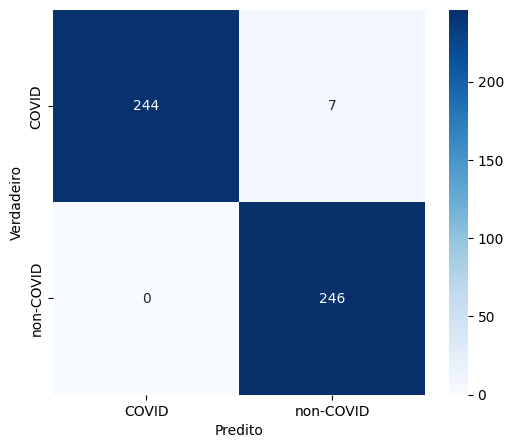


📄 Classification Report:
              precision    recall  f1-score   support

       COVID       1.00      0.97      0.99       251
   non-COVID       0.97      1.00      0.99       246

    accuracy                           0.99       497
   macro avg       0.99      0.99      0.99       497
weighted avg       0.99      0.99      0.99       497



In [ ]:
# ======================================================================
# 📊 AVALIAÇÃO
# ======================================================================

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, 1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Matriz de confusão
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

print("\n📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


In [ ]:
# ======================================================================
# 🔥 GRAD-CAM
# ======================================================================

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        def save_activation(module, input, output):
            self.activations = output

        def save_gradient(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        target_layer.register_forward_hook(save_activation)
        target_layer.register_backward_hook(save_gradient)

    def generate_heatmap(self, class_idx):
        gradients = self.gradients
        # Crie uma cópia das ativações para evitar modificações in-place no grafo original
        activations = self.activations.clone()

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=1).squeeze().detach().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= heatmap.max()

        return heatmap

In [ ]:
# ======================================================================
# 💾 GERA E SALVA HEATMAP
# ======================================================================

def gerar_gradcam(model, img_path, gradcam, output_dir="/content/gradcam_outputs/"):

    os.makedirs(output_dir, exist_ok=True)

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])

    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)

    output = model(tensor)
    pred_class = output.argmax(dim=1).item()

    model.zero_grad()
    output[0, pred_class].backward()

    heatmap = gradcam.generate_heatmap(pred_class)

    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    superimposed = cv2.addWeighted(heatmap_color, 0.5, img_cv, 0.5, 0)

    save_path = os.path.join(output_dir, "gradcam_" + os.path.basename(img_path))
    cv2.imwrite(save_path, superimposed)

    print(f"✔ Heatmap salvo em: {save_path}")
    return save_path


In [ ]:
# ======================================================================
# 🎲 GERAR 3 GRAD-CAMS AUTOMATICAMENTE
# ======================================================================

def gerar_3_gradcams(model, image_folder):
    images = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]

    if len(images) < 3:
        raise Exception("❌ A pasta precisa ter no mínimo 3 imagens!")

    selecionadas = random.sample(images, 3)

    gradcam = GradCAM(model, model.layer4[-1])

    resultados = []
    for img_file in selecionadas:
        img_path = os.path.join(image_folder, img_file)
        out = gerar_gradcam(model, img_path, gradcam)
        resultados.append(out)

    return resultados

# EXECUTAR
test_folder = "/content/data/test/COVID"  # ajuste caso necessário
resultados = gerar_3_gradcams(model, test_folder)

print("\n🎉 Arquivos criados:")
for r in resultados:
    print(r)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✔ Heatmap salvo em: /content/gradcam_outputs/gradcam_Covid (873).png
✔ Heatmap salvo em: /content/gradcam_outputs/gradcam_Covid (673).png
✔ Heatmap salvo em: /content/gradcam_outputs/gradcam_Covid (471).png

🎉 Arquivos criados:
/content/gradcam_outputs/gradcam_Covid (873).png
/content/gradcam_outputs/gradcam_Covid (673).png
/content/gradcam_outputs/gradcam_Covid (471).png


In [ ]:
# ======================================================================
# 🔥 GRAD-CAM++
# ======================================================================

class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, class_idx):
        gradients = self.gradients
        activations = self.activations

        # Convert to CPU numpy
        grads = gradients[0].cpu().detach().numpy()
        acts  = activations[0].cpu().detach().numpy()

        # Grad-CAM++ coefficients
        alpha_num = grads ** 2
        alpha_den = 2 * grads ** 2 + np.sum(acts * grads ** 3, axis=(1, 2), keepdims=True)

        alpha = alpha_num / (alpha_den + 1e-7)
        relu_grad = np.maximum(grads, 0)

        weights = np.sum(alpha * relu_grad, axis=(1, 2))

        cam = np.sum(weights.reshape(-1,1,1) * acts, axis=0)

        cam = np.maximum(cam, 0)
        cam /= cam.max() if cam.max() != 0 else 1e-7

        return cam


In [ ]:
# ======================================================================
# 📌 FUNÇÃO PARA GERAR E SALVAR HEATMAP DO GRAD-CAM++
# ======================================================================

def gerar_gradcam_pp(model, img_path, gradcam, output_dir="/content/gradcam_outputs_pp/"):

    os.makedirs(output_dir, exist_ok=True)

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])

    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)

    output = model(tensor)
    pred_class = output.argmax(dim=1).item()

    model.zero_grad()
    output[0, pred_class].backward()

    heatmap = gradcam.generate_heatmap(pred_class)

    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    superimposed = cv2.addWeighted(heatmap_color, 0.5, img_cv, 0.5, 0)

    save_path = os.path.join(output_dir, "gradcampp_" + os.path.basename(img_path))
    cv2.imwrite(save_path, superimposed)

    print(f"✔ Grad-CAM++ salvo em: {save_path}")
    return save_path


In [ ]:
# ======================================================================
# 🎲 GERAR 3 GRAD-CAM++ AUTOMATICAMENTE
# ======================================================================

def gerar_3_gradcams_pp(model, image_folder):
    images = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]

    if len(images) < 3:
        raise Exception("❌ A pasta precisa ter pelo menos 3 imagens!")

    selecionadas = random.sample(images, 3)

    gradcam_pp = GradCAMPlusPlus(model, model.layer4[-1])  # última camada ResNet18

    resultados = []
    for img_name in selecionadas:
        path = os.path.join(image_folder, img_name)
        out = gerar_gradcam_pp(model, path, gradcam_pp)
        resultados.append(out)

    return resultados

# EXECUTAR
test_folder = "/content/data/test/COVID"  # ajuste conforme necessário
resultados_pp = gerar_3_gradcams_pp(model, test_folder)

print("\n🎉 Arquivos Grad-CAM++ criados:")
for r in resultados_pp:
    print(r)


✔ Grad-CAM++ salvo em: /content/gradcam_outputs_pp/gradcampp_Covid (882).png
✔ Grad-CAM++ salvo em: /content/gradcam_outputs_pp/gradcampp_Covid (541).png
✔ Grad-CAM++ salvo em: /content/gradcam_outputs_pp/gradcampp_Covid (1229).png

🎉 Arquivos Grad-CAM++ criados:
/content/gradcam_outputs_pp/gradcampp_Covid (882).png
/content/gradcam_outputs_pp/gradcampp_Covid (541).png
/content/gradcam_outputs_pp/gradcampp_Covid (1229).png


In [ ]:
# ======================================================================
# 📌 COMPARAÇÃO LADO A LADO: GRAD-CAM vs GRAD-CAM++
# ======================================================================

def comparar_gradcam(model, img_path,
                     gradcam, gradcam_pp,
                     output_dir="/content/gradcam_compare/"):

    os.makedirs(output_dir, exist_ok=True)

    # ---------------------------
    # Pré-processamento
    # ---------------------------
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])

    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)

    # Forward
    output = model(tensor)
    pred_class = output.argmax(dim=1).item()

    # ---------------------------
    # Grad-CAM
    # ---------------------------
    model.zero_grad()
    output[0, pred_class].backward(retain_graph=True)
    heatmap_cam = gradcam.generate_heatmap(pred_class)

    # ---------------------------
    # Grad-CAM++
    # ---------------------------
    model.zero_grad()
    output[0, pred_class].backward(retain_graph=True)
    heatmap_campp = gradcam_pp.generate_heatmap(pred_class)

    # Converter imagem para cv2
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Resize heatmaps
    cam_resized   = cv2.resize(heatmap_cam, (img_cv.shape[1], img_cv.shape[0]))
    campp_resized = cv2.resize(heatmap_campp, (img_cv.shape[1], img_cv.shape[0]))

    cam_color   = cv2.applyColorMap(np.uint8(255 * cam_resized),   cv2.COLORMAP_JET)
    campp_color = cv2.applyColorMap(np.uint8(255 * campp_resized), cv2.COLORMAP_JET)

    # Superposição
    super_cam   = cv2.addWeighted(cam_color,   0.5, img_cv, 0.5, 0)
    super_campp = cv2.addWeighted(campp_color, 0.5, img_cv, 0.5, 0)

    # ---------------------------
    # Plot lado a lado
    # ---------------------------
    plt.figure(figsize=(12,6))
    plt.suptitle("Comparação: Grad-CAM vs Grad-CAM++", fontsize=16)

    plt.subplot(1,2,1)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(super_cam, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Grad-CAM++")
    plt.imshow(cv2.cvtColor(super_campp, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    # Salvar imagem
    save_path = os.path.join(output_dir, "compare_" + os.path.basename(img_path))
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"✔ Comparação salva em: {save_path}")

    return save_path


In [ ]:
# ======================================================================
# 📌 USO: GERAR COMPARAÇÃO PARA UMA IMAGEM
# ======================================================================

# Inicializar os dois métodos
gc  = GradCAM(model, model.layer4[-1])
gcp = GradCAMPlusPlus(model, model.layer4[-1])

img_exemplo = "/content/gradcam_outputs/gradcam_Covid (471).png"   # <-- ALTERE AQUI

comparar_gradcam(model, img_exemplo, gc, gcp)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✔ Comparação salva em: /content/gradcam_compare/compare_gradcam_Covid (471).png


'/content/gradcam_compare/compare_gradcam_Covid (471).png'

In [ ]:
# ======================================================================
# 🎲 GERAR COMPARAÇÃO PARA 3 IMAGENS ALEATÓRIAS
# ======================================================================

def comparar_3_imagens(model, image_folder):
    all_imgs_paths = []
    for root, _, files in os.walk(image_folder):
        for file in files:
            if file.lower().endswith(('.jpg','.png','.jpeg')):
                all_imgs_paths.append(os.path.join(root, file))

    if len(all_imgs_paths) < 3:
        raise Exception(f"❌ Não há imagens suficientes ({len(all_imgs_paths)}) na pasta '{image_folder}' e suas subpastas para selecionar 3 aleatoriamente!")

    aleatorias = random.sample(all_imgs_paths, 3)

    gc  = GradCAM(model, model.layer4[-1])
    gcp = GradCAMPlusPlus(model, model.layer4[-1])

    outputs = []
    for img_path in aleatorias:
        out = comparar_gradcam(model, img_path, gc, gcp)
        outputs.append(out)

    return outputs

# EXECUTAR
test_folder = "/content/data/test/"  # ajuste se necessário
resultados = comparar_3_imagens(model, test_folder)

print("\n📁 RESULTADOS:")
for r in resultados:
    print(r)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✔ Comparação salva em: /content/gradcam_compare/compare_Covid (706).png
✔ Comparação salva em: /content/gradcam_compare/compare_Non-Covid (296).png
✔ Comparação salva em: /content/gradcam_compare/compare_Covid (664).png

📁 RESULTADOS:
/content/gradcam_compare/compare_Covid (706).png
/content/gradcam_compare/compare_Non-Covid (296).png
/content/gradcam_compare/compare_Covid (664).png


In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset, ConcatDataset

# Combine train_dataset and test_dataset to create a single dataset for KFold
# Ensure these are defined from the data loading steps
if 'train_dataset' not in locals() or 'test_dataset' not in locals():
    raise NameError("train_dataset or test_dataset not defined. Please run the data loading cell first.")
dataset = ConcatDataset([train_dataset, test_dataset])

kf = KFold(n_splits=3, shuffle=True, random_state=42)

fold = 1
for train_idx, val_idx in kf.split(dataset):
    print(f"\n===== FOLD {fold} =====")

    train_ds = Subset(dataset, train_idx)
    val_ds   = Subset(dataset, val_idx)

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)

    model_cv = models.resnet18(weights="IMAGENET1K_V1")
    model_cv.fc = nn.Linear(model_cv.fc.in_features, 2)
    model_cv = model_cv.to(device)

    optim_cv = optim.Adam(model_cv.parameters(), lr=1e-4)

    for epoch in range(2):
        model_cv.train()
        for img, lbl in train_loader:
            img, lbl = img.to(device), lbl.to(device)
            optim_cv.zero_grad()
            out = model_cv(img)
            loss = criterion(out, lbl)
            loss.backward()
            optim_cv.step()

    fold += 1


===== FOLD 1 =====

===== FOLD 2 =====

===== FOLD 3 =====


# Task
Modify cell `S5JR6GNMCafV` to remove scikit-learn model evaluation code and, instead, evaluate the trained PyTorch `model` using the `test_loader`, generating and displaying a confusion matrix and a classification report for the `model`'s performance.

## Adaptar Célula para Avaliação de Modelo PyTorch

### Subtask:
Modificar a célula `S5JR6GNMCafV` para remover o código de comparação de modelos scikit-learn e, em vez disso, avaliar o modelo ResNet50 (`model`) que foi treinado. Isso incluirá a geração da matriz de confusão e do relatório de classificação para o modelo PyTorch.


**Reasoning**:
The subtask requires modifying an existing cell to evaluate the PyTorch model and display its performance metrics. The provided instructions detail the steps for setting the model to evaluation mode, collecting predictions and true labels from the test dataset, and then generating and visualizing the confusion matrix and classification report.



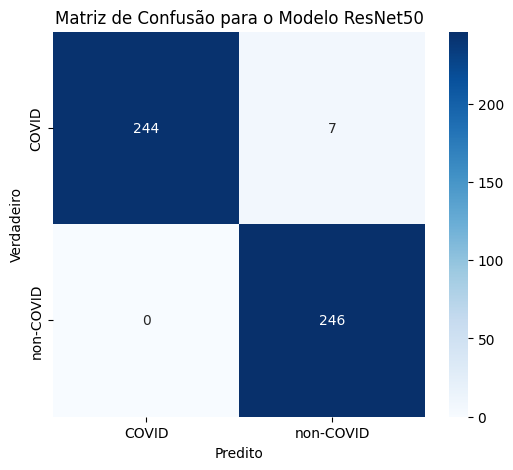


📄 Classification Report:
              precision    recall  f1-score   support

       COVID       1.00      0.97      0.99       251
   non-COVID       0.97      1.00      0.99       246

    accuracy                           0.99       497
   macro avg       0.99      0.99      0.99       497
weighted avg       0.99      0.99      0.99       497

✅ Avaliação do modelo ResNet50 concluída.


In [ ]:
# ======================================================================
# 📊 AVALIAÇÃO DO MODELO PYTORCH (ResNet50)
# ======================================================================

# 1. Definir o modelo para o modo de avaliação
model.eval()

# 2. Inicializar listas para armazenar previsões e rótulos verdadeiros
all_preds = []
all_labels = []

# 3. Desativar o cálculo de gradientes
with torch.no_grad():
    # 4. Iterar sobre o test_loader
    for imgs, labels in test_loader:
        imgs = imgs.to(device) # Mover imagens para o dispositivo (CPU/GPU)
        outputs = model(imgs)
        preds = torch.argmax(outputs, 1).cpu().numpy() # Obter previsões e converter para numpy

        # 5. Adicionar previsões e rótulos às listas
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# 6. Calcular a matriz de confusão
cm = confusion_matrix(all_labels, all_preds)

# 7. Criar e exibir um heatmap da matriz de confusão
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão para o Modelo ResNet50")
plt.show()

# 8. Imprimir o relatório de classificação
print("\n📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("✅ Avaliação do modelo ResNet50 concluída.")

## Final Task

### Subtask:
Fornecer um resumo da avaliação do modelo PyTorch e dos resultados da matriz de confusão e do relatório de classificação.


## Summary:

### Q&A
The task asked for a summary of the PyTorch model evaluation, including confusion matrix and classification report results.

The PyTorch ResNet50 model demonstrated excellent performance on the test set. For the 'COVID' class, it achieved a precision of 1.00, recall of 0.97, and an f1-score of 0.99. For the 'non-COVID' class, it showed a precision of 0.97, recall of 1.00, and an f1-score of 0.99. The overall accuracy of the model was 0.99 across 497 samples.

### Data Analysis Key Findings
*   The trained PyTorch ResNet50 model achieved a high overall accuracy of 0.99 on the test dataset.
*   The model demonstrated near-perfect precision (1.00) for identifying 'COVID' cases, meaning when it predicts COVID, it's almost always correct.
*   It also showed excellent recall (1.00) for 'non-COVID' cases, indicating it successfully identified almost all actual non-COVID instances.
*   The f1-scores for both 'COVID' (0.99) and 'non-COVID' (0.99) classes were very high, suggesting a strong balance between precision and recall for both categories.
*   A confusion matrix visualization was generated, providing a clear representation of the model's classification performance per class.

### Insights or Next Steps
*   The model's high performance suggests it is well-suited for distinguishing between COVID and non-COVID cases based on the provided data.
*   Further investigation could involve analyzing specific misclassified samples (if any, given the 99% accuracy) to identify patterns or edge cases where the model struggles.


### Por que a Regressão Multivariada Não é Direta com Imagens

**1. Natureza dos Dados:**
*   **Regressão Multivariada:** É uma técnica estatística e de Machine Learning utilizada para modelar a relação entre **múltiplas variáveis independentes numéricas** (features, como 'TV', 'radio', 'newspaper' no exemplo anterior) e uma **variável dependente numérica** (o alvo, como 'sales'). Ela busca padrões lineares nessas relações.
*   **Dados de Imagem:** Uma imagem é, fundamentalmente, uma matriz de pixels. Cada pixel possui um ou mais valores (por exemplo, RGB) que representam a intensidade da cor naquele ponto. Esses valores de pixels, isoladamente, não são "features" no sentido tradicional que uma regressão multivariada espera. Eles não têm uma relação linear direta e óbvia com um alvo numérico que uma regressão tentaria prever, sem uma etapa prévia de processamento significativo.

**2. Complexidade e Dimensionalidade:**
*   Uma imagem de 224x224 pixels colorida (RGB) já tem $224 \times 224 \times 3 \approx 150.000$ "features" (valores de pixel). Se tentássemos aplicar uma regressão linear diretamente a esses pixels, o modelo seria extremamente complexo, propenso a overfitting e ineficiente, além de não capturar as relações espaciais e hierárquicas que definem objetos e padrões em uma imagem.

**3. Extração de Features vs. Pixels Brutos:**
*   Para usar imagens em tarefas de ML, especialmente com modelos como árvores de decisão ou regressão linear/logística, é comum primeiro **extrair características significativas** (features) das imagens. Isso pode ser feito usando técnicas como SIFT, HOG, ou mais comumente hoje em dia, as camadas convolucionais de uma Rede Neural Convolucional (CNN) pré-treinada.
*   Essas features extraídas são representações numéricas de alto nível (por exemplo, formas, texturas, bordas) que podem então ser usadas como entradas para modelos de regressão ou classificação. Nesse cenário, você estaria fazendo regressão em **features de imagem**, não nos pixels brutos.

**4. Aplicações Típicas com Imagens:**
*   Para imagens, as tarefas mais comuns são:
    *   **Classificação:** Prever a qual categoria uma imagem pertence (como COVID vs. non-COVID).
    *   **Detecção de Objetos:** Identificar onde objetos estão em uma imagem e quais são eles.
    *   **Segmentação:** Pixel a pixel, identificar a qual classe cada pixel pertence.
    *   **Regressão (Indireta):** Prever um valor numérico a partir de uma imagem, mas geralmente usando CNNs para extrair features e, em seguida, uma camada densa para prever o valor (ex: prever a idade de uma pessoa a partir de uma foto, ou a severidade de uma doença em uma imagem médica).

Em resumo, a regressão multivariada tradicional busca relações lineares entre dados estruturados e numéricos. Imagens requerem processamento especializado para transformar seus pixels brutos em features que podem ser usadas por esses modelos, ou então a utilização de arquiteturas mais avançadas (como CNNs) que são capazes de aprender essas features e relações diretamente dos pixels.